This notebook was run with Python 3.6 in a venv. I want to move to more updated dependencies and so I'm dropping this notebook and moving to a new, containerized environment without coffea.

# hpstr:ptrless
Using `hpstr:ptrless` to create tuples that can be loaded by `uproot` and `awkward`.

In [1]:
import uproot
import awkward as ak
import numpy as np

import coffea
import coffea.nanoevents

import hist
import matplotlib.pyplot as plt
import matplotlib
import mplhep
%matplotlib inline
matplotlib.style.use(mplhep.style.ROOT)

from pyidm import roast

# Reco Vtx Distribution

In [26]:
bkgd = {
    'wab': roast.vertices('/data/cmszfs1/user/eichl008/hps/idm/bkgd/wab/tuples/wab-beam_nruns_2000_startrun_1.root'),
    'tritrig': roast.vertices('/data/cmszfs1/user/eichl008/hps/idm/bkgd/tritrig/tuples/tritrig-beam_nruns_200_startrun_1.root')
}

In [27]:
def load_vertices_particles(fp):
    events = roast.from_root(fp)
    return {
        'vtx' : roast.vertices(fp),
        'particles': roast.mc_particles(events)
    }
def mc_particles(events):
    if isinstance(events,str):
        return roast.mc_particles(roast.from_root(events))
    return roast.mc_particles(events)
signal = {
    'reco' : load_vertices_particles('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_122_nevents_10k.root'),
    'sim'  : mc_particles('/local/cms/user/eichl008/hps/idm/signal/sim_idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_1_nevents_10k.root')
}

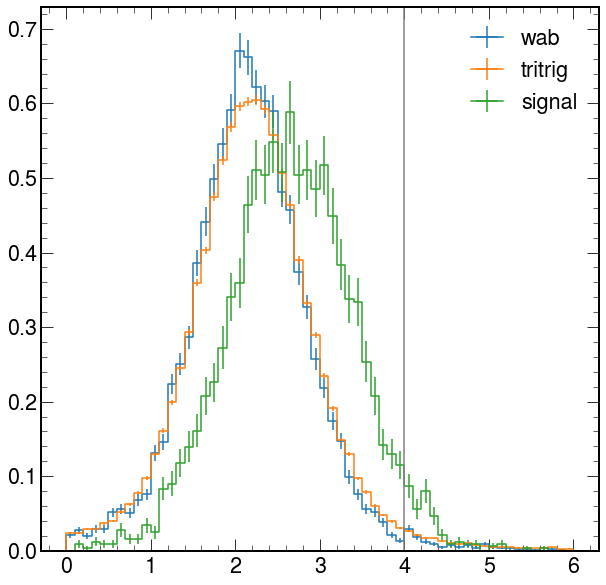

In [13]:
tdiff = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal'],
        name='type'
    ),
    hist.axis.Regular(
        60,0,6,
        name = 'tdiff',
        label = '$e^-$ Track-Cluster $\Delta t$ [ns]'
    )
)
for t, v in vtx.items():
    tdiff.fill(
        type = t,
        tdiff = abs(v.electron.track.time - v.electron.cluster.time + 43.0),
    )
tdiff.plot(density = True)
plt.axvline(4, color='gray')
plt.legend()
plt.show()

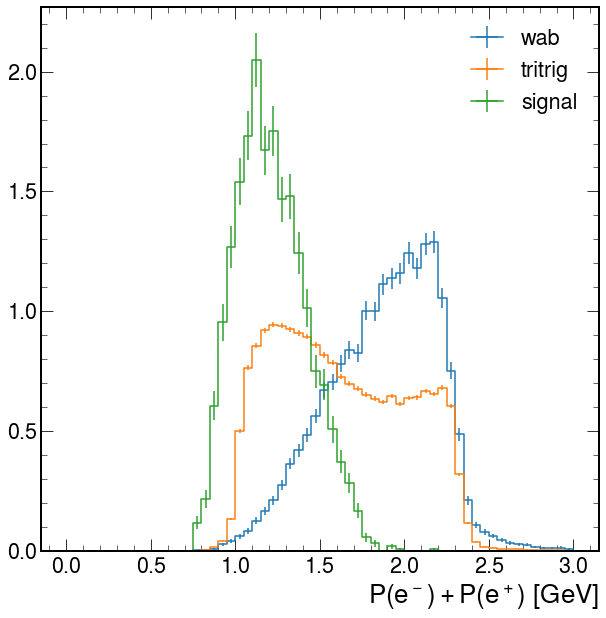

In [21]:
psum = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal'],
        name='type'
    ),
    hist.axis.Regular(
        60,0,3,
        name = 'psmu',
        label = '$P(e^-)+P(e^+)$ [GeV]'
    )
)
for t, v in vtx.items():
    psum.fill(t, v.electron.track.p.mag + v.positron.track.p.mag)
psum.plot(density = True)
plt.xlabel('$P(e^-)+P(e^+)$ [GeV]')
plt.legend()
plt.show()

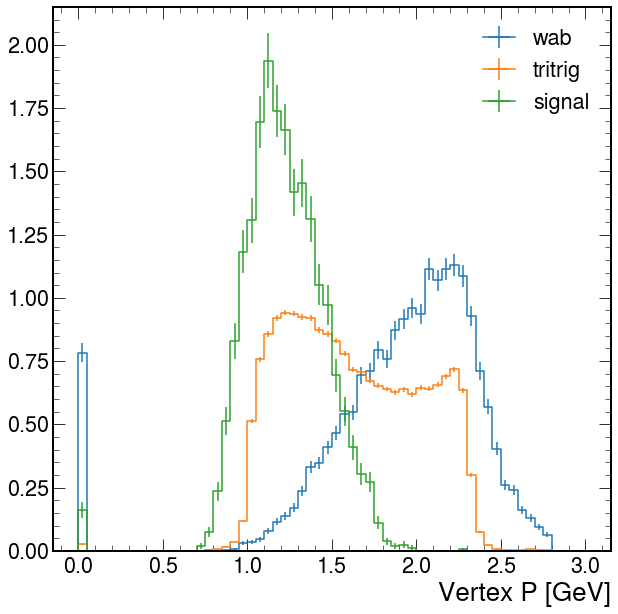

In [24]:
vtxp = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal'],
        name='type'
    ),
    hist.axis.Regular(
        60,0,3,
        name = 'vtxp',
        label = '$P(e^-)+P(e^+)$ [GeV]'
    )
)
for t, v in vtx.items():
    vtxp.fill(t, (v.p.fX**2+v.p.fY**2+v.p.fZ**2)**0.5)
vtxp.plot(density = True)
plt.xlabel('Vertex P [GeV]')
plt.legend()
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


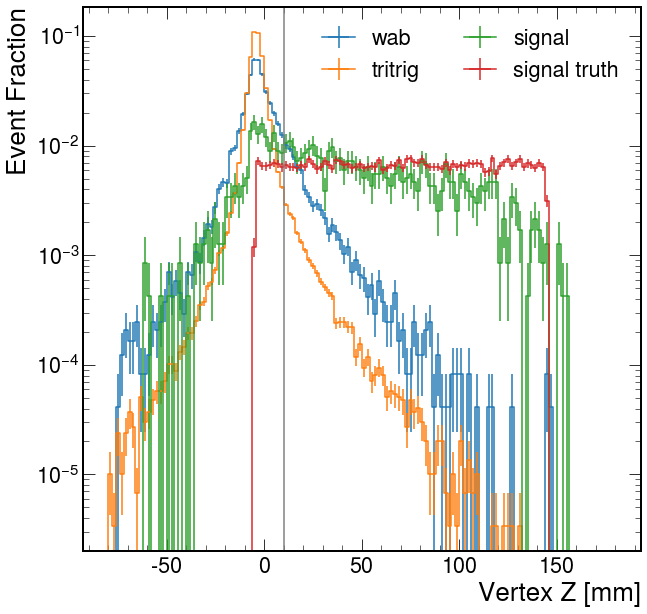

In [28]:
vtxz = hist.Hist(
    hist.axis.StrCategory(
        ['wab','tritrig','signal','signal truth'],
        name='type'
    ),
    hist.axis.Regular(
        130,-80,180,
        name = 'vtxz',
        label = 'Vertex Z [mm]'
    )
)
for t, v in bkgd.items():
    vtxz.fill(
        type = t,
        vtxz = v.pos.fZ,
    )
#vtxz.fill(
#    type = 'signal truth',
#    vtxz = chi2.ep.z
#)
vtxz.fill(
    type = 'signal',
    vtxz = signal['reco']['vtx'].pos.fZ
)
vtxz.fill(
    type = 'signal truth',
    vtxz = ak.flatten(
        signal['sim'][
            (signal['sim'].pdg == 1000023)
            #&(ak.count(
            #    signal['reco']['vtx'].pos.fZ,
            #    axis=1
            #)==1)
        ].ep.z)
)
vtxz.plot(density = True)
plt.yscale('log')
plt.xlabel('Vertex Z [mm]')
plt.ylabel('Event Fraction')
plt.legend(
    ncol = 2,
#    loc = 'lower center',
#    bbox_to_anchor=(0.5,1)
)
plt.axvline(10, color='gray')
plt.savefig('plots/reco-vertex-100.pdf', bbox_inches='tight')
plt.show()

In [2]:
events = roast.from_root('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_122_nevents_10k.root')

/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.tracker_hits_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.particle_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.cov_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable

In [7]:
d = {
    'vertex': roast.VertexReformatter(events)(),
    'mc_particle': roast.mc_particles(events)
}

In [9]:
ak.count(d['vertex'].chi2, axis=1)

<Array [1, 1, 0, 0, 1, 0, ... 1, 0, 1, 0, 1, 0] type='2492 * int64'>

In [28]:
event_sel = (
    ak.count(d['vertex'].chi2, axis=1) == 1
)
vertices = ak.flatten(d['vertex'][event_sel])
vertices

<Array [{chi2: 695, ndf: -999, pos: {, ... ] type='1177 * Vertex["chi2": float64...'>

In [18]:
chi2 = ak.flatten(d['mc_particle'][event_sel][d['mc_particle'][event_sel].pdg==1000023])
chi2.ep.z

<Array [139, 114, 49.5, ... 37.2, 123, -2.22] type='1177 * float64[parameters={"...'>

In [22]:
# from MG
mg_rate = 2.415e-14 # GeV - mchi=100MeV, delta=60MeV, map=300MeV
#mg_rate = 7.174e-15 # GeV - mchi=30MeV, delta=18MeV, map=90MeV

In [23]:
def ctau(rate):
    c = 3.00e10  # cm/s
    hbar = 6.58e-25  # GeV*sec
    return c*hbar/rate

In [24]:
def weight_by_z(z, gamma_c_tau):
    return np.exp((-4.3 - z)/gamma_c_tau)/gamma_c_tau

In [29]:
vertices.pos.fZ

<Array [-0.53, 52.1, 48.4, ... 92.4, -0.607] type='1177 * float64'>

In [ ]:
weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass * ctau(mg_rate))[vertices.pos.fZ > 10]

<Array [2.68e-07, 0.000707, ... 0.00027, 4e-07] type='825 * float64'>

In [80]:
import pandas as pd
df = pd.DataFrame({
    'eps2' : np.logspace(0, -6)
})
df['ctau'] = df.eps2.apply(lambda eps2 : ctau(mg_rate * eps2 / 1e-4))
df['reweightsum'] = df.ctau.apply(lambda a_ctau: ak.sum(weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass*a_ctau)))
df['reweightsum_pass'] = df.ctau.apply(
    lambda a_ctau:
    ak.sum(weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass * a_ctau)[vertices.pos.fZ > 10])
)
df['num_pass'] = ak.count(vertices)
df['num_thrown'] = 122*10000
# def reweight_cut(a_ctau):
#     reweights = weight_by_z(chi2.ep.z, chi2.p.energy/chi2.p.mass * a_ctau)
#     return ak.sum(reweights), ak.sum(reweights[vertices.pos.fZ > 10])
# df[['reweightsum','reweightsum_pass']] = df.ctau.apply(reweight_cut)
df['z_cut_eff'] = df.reweightsum_pass / df.reweightsum
df['event_selection_eff'] = df.num_pass / df.num_thrown
df['full_eff'] = df.z_cut_eff * df.event_selection_eff
df['prod_rate'] = (df.eps2)*3.029015e+05 # eps=1 value copied from prior table for HPS 2016 Lumi
df['full_rate'] = df.full_eff*df.prod_rate

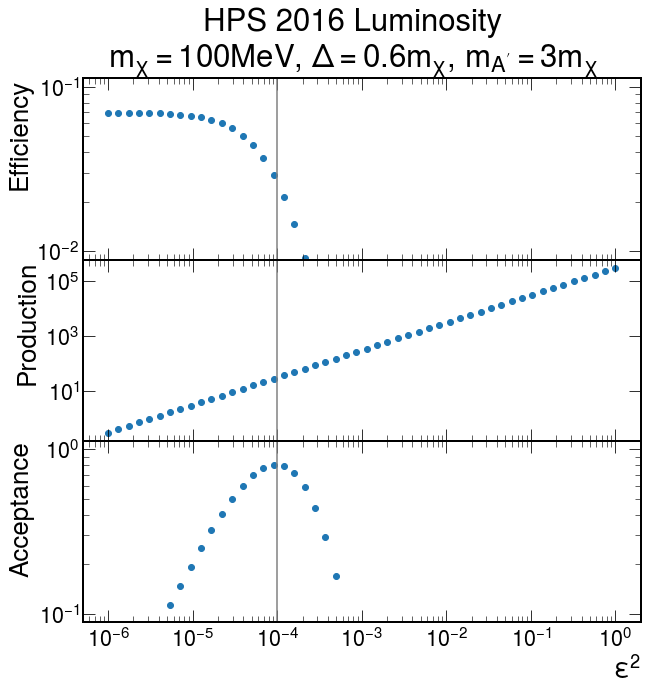

In [79]:
fig, (eff, prod, full) = plt.subplots(
    nrows = 3,
    sharex = 'col',
    gridspec_kw = dict(
        hspace=0
    )
)

for ax in (eff, prod, full):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.axvline(1e-4, color='gray')

eff.scatter(df.eps2, df.full_eff)
eff.set_ylabel('Efficiency')

prod.scatter(df.eps2, df.prod_rate)
prod.set_ylabel('Production')

full.scatter(df.eps2, df.full_rate)
full.set_ylabel('Acceptance')
full.set_xlabel('$\\epsilon^2$')

fig.suptitle("""HPS 2016 Luminosity
$m_\\chi=100$MeV, $\Delta = 0.6m_\\chi$, $m_{A'}=3m_\\chi$""")
#fig.savefig('plots/mchi-100-rdmchi-0.6-rmap-3-acc-rate.pdf', bbox_inches='tight')
plt.show()

In [79]:
weights_eps2 = zweight(z, gamma * ctau(mg_rate))

In [82]:
print(ak.sum(weights_eps2), ak.sum(weights_eps2[z > 10.]), ak.sum(weights_eps2[z > 10])/ak.sum(weights_eps2))

68.24330371685845 9.744202574906533 0.14278620823129023


(array([5.92153674e+01, 7.13507375e+00, 1.44828335e+00, 3.28861219e-01,
        8.59960671e-02, 2.20019053e-02, 5.66640452e-03, 1.40810601e-03,
        5.10544180e-04, 1.35008268e-04]),
 array([ -4.28556887,  10.67204563,  25.62966013,  40.58727463,
         55.54488913,  70.50250363,  85.46011813, 100.41773263,
        115.37534713, 130.33296163, 145.29057613]),
 <BarContainer object of 10 artists>)

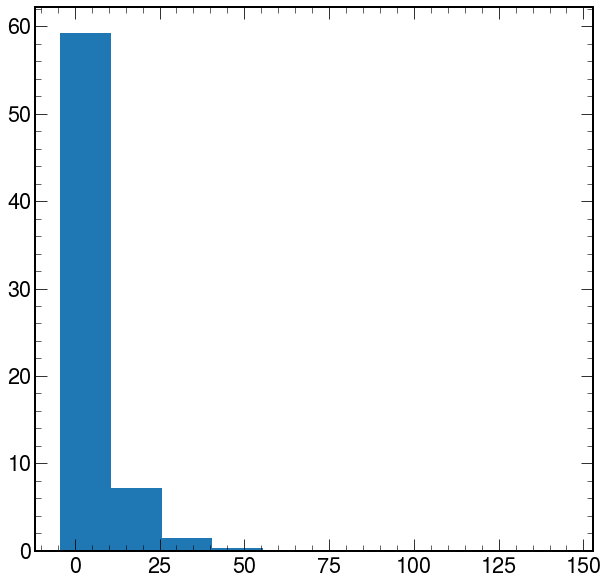

In [80]:
plt.hist(
    z,
    weights = weights_eps2
)

In [30]:
ak.sum(signal['reco']['vtx'].pos.fZ > 10.) / (122 * 10000)

0.0006762295081967213

# Initial Single-Point Analysis

In [3]:
sim = roast.from_root('/local/cms/user/eichl008/hps/idm/signal/sim_idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_1_nevents_10k.root')

In [4]:
rec = roast.from_root('/local/cms/user/eichl008/hps/idm/signal/idm_2pt3_mchi_100_rmap_3.00_rdmchi_0.60_nruns_122_nevents_10k.root')

/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.tracker_hits_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.particle_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable by Uproot")
/export/scratch/users/eichl008/hps/idm/reach/2016/venv/lib64/python3.6/site-packages/coffea/nanoevents/mapping/uproot.py:102: UserWarning: Skipping UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.electron_.track_.cov_ as it is not interpretable by Uproot
  warnings.warn(f"Skipping {key} as it is not interpretable

In [5]:
rec_particles = roast.mc_particles(rec)

In [6]:
particles = roast.mc_particles(sim)
ecal_hits = roast.mc_ecal_hits(sim)
tracker_hits = roast.mc_tracker_hits(sim)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


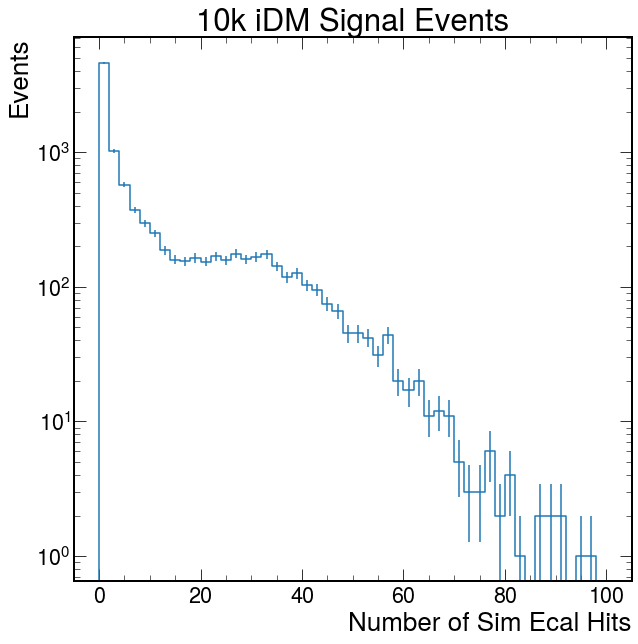

In [7]:
nhits = hist.Hist(
    hist.axis.Regular(
        start=0, stop=100, bins=50, 
        flow=True,
        name='nhits',
        label='Num Ecal Sim Hits'
    )
).fill(
    ak.count(ecal_hits.x, axis=1)
)
nhits.plot()
plt.ylabel('Events')
plt.xlabel('Number of Sim Ecal Hits')
plt.title('10k iDM Signal Events')
plt.yscale('log')
plt.savefig('plots/n-sim-ecal-hits.pdf', bbox_inches='tight')
plt.show()

In [8]:
hit_loc = hist.Hist(
    hist.axis.Regular(51,-25.5,25.5,name='ix',label='iX'),
    hist.axis.Regular(13,-6.5,6.5,name='iy',label='iY'),
).fill(
    ix = ak.flatten(ecal_hits.ix),
    iy = ak.flatten(ecal_hits.iy)
)

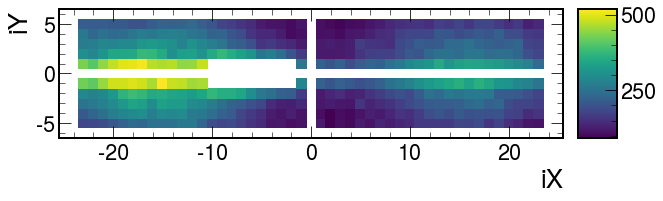

In [9]:
hit_loc.plot(
    cmin=1,
    #norm='log'
)
plt.gca().set_aspect('equal')

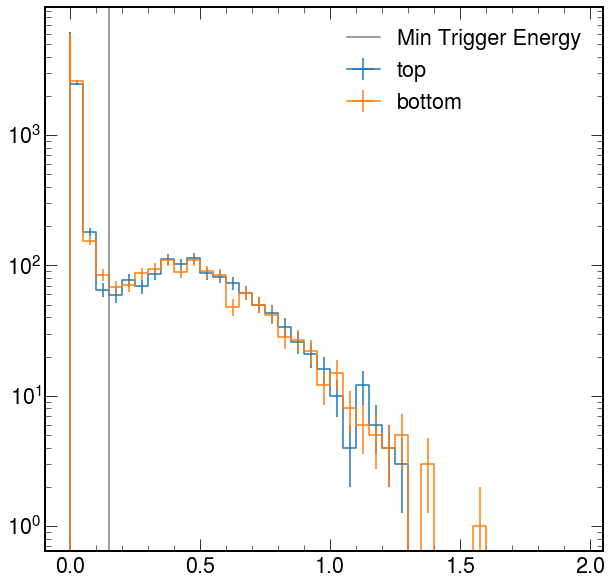

In [10]:
sim_trigger = hist.Hist(
    hist.axis.StrCategory(
        ['top','bottom'],
        name='half',
        label='Half'
    ),
    hist.axis.Variable(
        np.concatenate(([0,1e-3],np.arange(0.05,2,0.05))),
        name='tot_sim_energy',
        label='Total Sim Energy [?GeV?]'
    )
)
sim_trigger.fill(
    half='top',
    tot_sim_energy = ak.sum(ecal_hits.energy[ecal_hits.iy > 0], axis=1)
)
sim_trigger.fill(
    half='bottom',
    tot_sim_energy = ak.sum(ecal_hits.energy[ecal_hits.iy < 0], axis=1)
)
sim_trigger.plot()
plt.axvline(0.15, label='Min Trigger Energy',color='gray')
plt.legend()
plt.yscale('log')
plt.show()

In [11]:
obs = {
    'Produced Electron' : ak.flatten(particles[
        (particles.gen==1)&(particles.momPDG==1023)&(particles.pdg==+11)
    ]),
    'Produced Positron' : ak.flatten(particles[
        (particles.gen==1)&(particles.momPDG==1023)&(particles.pdg==-11)
    ]),
    'Recoil Electron' : ak.flatten(particles[
        (particles.gen==1)&(particles.pdg==+11)&(particles.momPDG==+11)
    ]),
    'Produced Electron (pass reco)' : ak.flatten(rec_particles[
        (rec_particles.gen==1)&(rec_particles.momPDG==1023)&(rec_particles.pdg==+11)
    ]),
    'Produced Positron (pass reco)' : ak.flatten(rec_particles[
        (rec_particles.gen==1)&(rec_particles.momPDG==1023)&(rec_particles.pdg==-11)
    ]),
    'Recoil Electron (pass reco)' : ak.flatten(rec_particles[
        (rec_particles.gen==1)&(rec_particles.pdg==+11)&(rec_particles.momPDG==+11)
    ]),
}

In [12]:
import matplotlib as mpl
from cycler import cycler

In [16]:
default_cycler = (cycler(color=['tab:blue', 'tab:orange', 'tab:purple', 'tab:blue', 'tab:orange', 'tab:purple']) +
                  cycler(linestyle=['-', '-', '-', '--', '--', '--']))
legend_artists = [
    mpl.lines.Line2D(
        [0],[0],
        lw=2, color='tab:blue',
        label = 'Produced Electron'
    ),
    mpl.lines.Line2D(
        [0],[0],
        lw=2, color='tab:orange',
        label = 'Produced Positron'
    ),
    mpl.lines.Line2D(
        [0],[0],
        lw=2, color='tab:purple',
        label = 'Recoil Electron'
    ),
    mpl.lines.Line2D(
        [0],[0],
        lw=2, color='black', ls='--',
        label = 'Passed Reco'
    ),
]
#plt.rc('axes', prop_cycle=default_cycler)

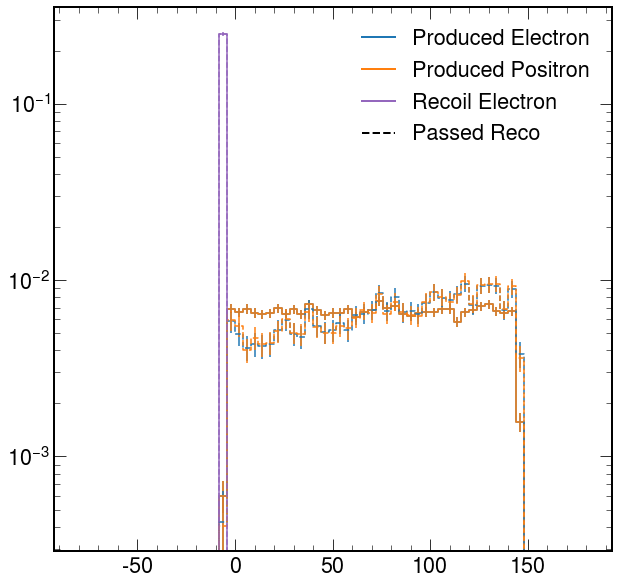

In [17]:
h = hist.Hist(
    hist.axis.StrCategory(
        list(obs.keys())
    ),
    hist.axis.Regular(
        65,-80,180,
        name = 'vtxz',
        label = 'Vertex Z [mm]'
    )
)
for name, particle in obs.items():
    h.fill(name, particle.vtx.z)
fig, ax = plt.subplots()
ax.set_prop_cycle(default_cycler)
for name in obs:
    h[name,:].plot(
        ax=ax,
        density=True,
        label = name
    )
plt.legend(
    handles=legend_artists
)
plt.yscale('log')
plt.show()

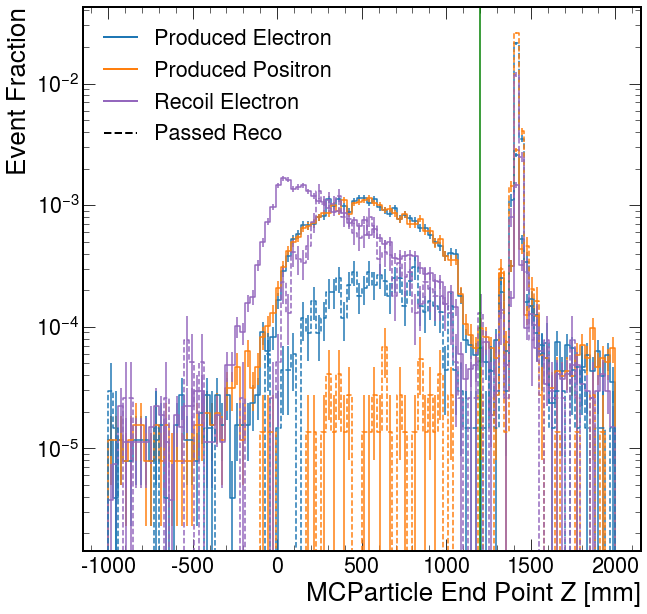

In [18]:
h = hist.Hist(
    hist.axis.StrCategory(
        list(obs.keys())
    ),
    hist.axis.Regular(
        100,-1000,2000,
        label = 'End Point Vertex Z [mm]'
    )
)
for name, particle in obs.items():
    
    h.fill(name, particle.ep.z)
fig, ax = plt.subplots()
ax.set_prop_cycle(default_cycler)
h.plot(ax=ax, density=True)
plt.axvline(1200, label='Ecal Start (ish)', color='g')
plt.xlabel('MCParticle End Point Z [mm]')
plt.ylabel('Event Fraction')
plt.yscale('log')
plt.legend(handles=legend_artists)
#plt.savefig('plots/prod-pair-z.pdf', bbox_inches='tight')
plt.show()

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


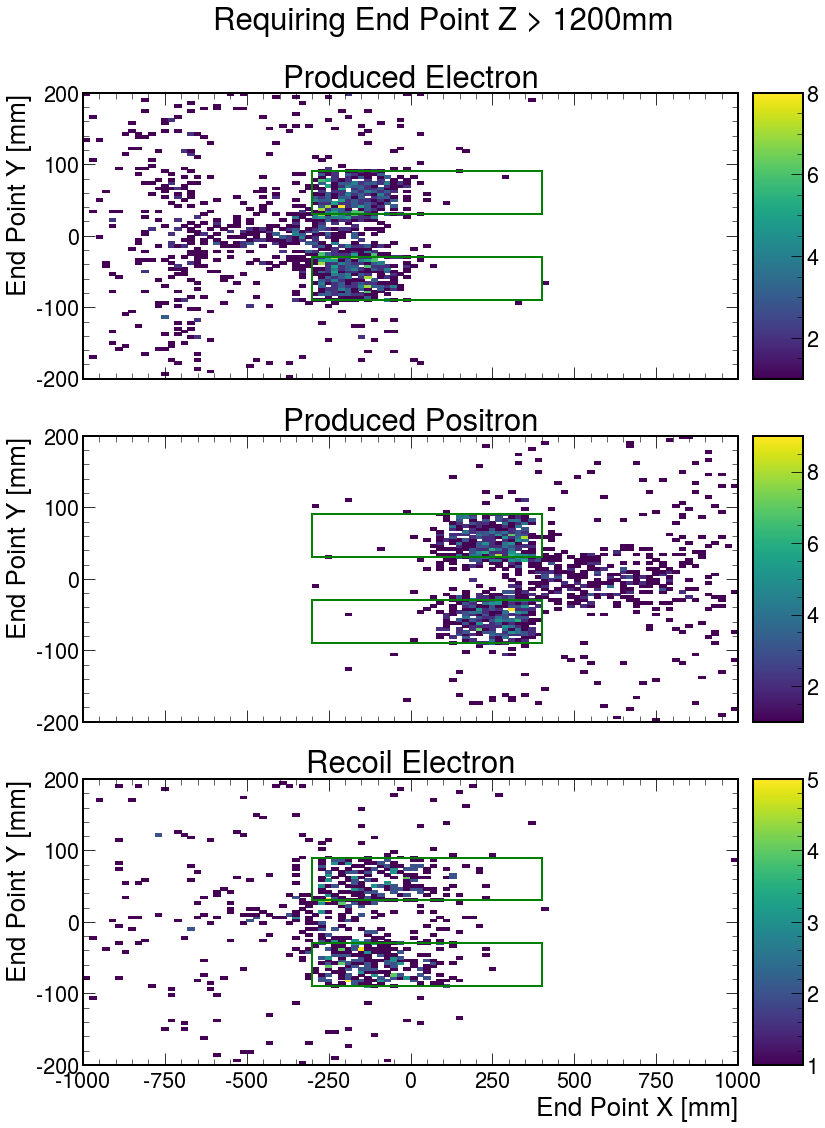

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


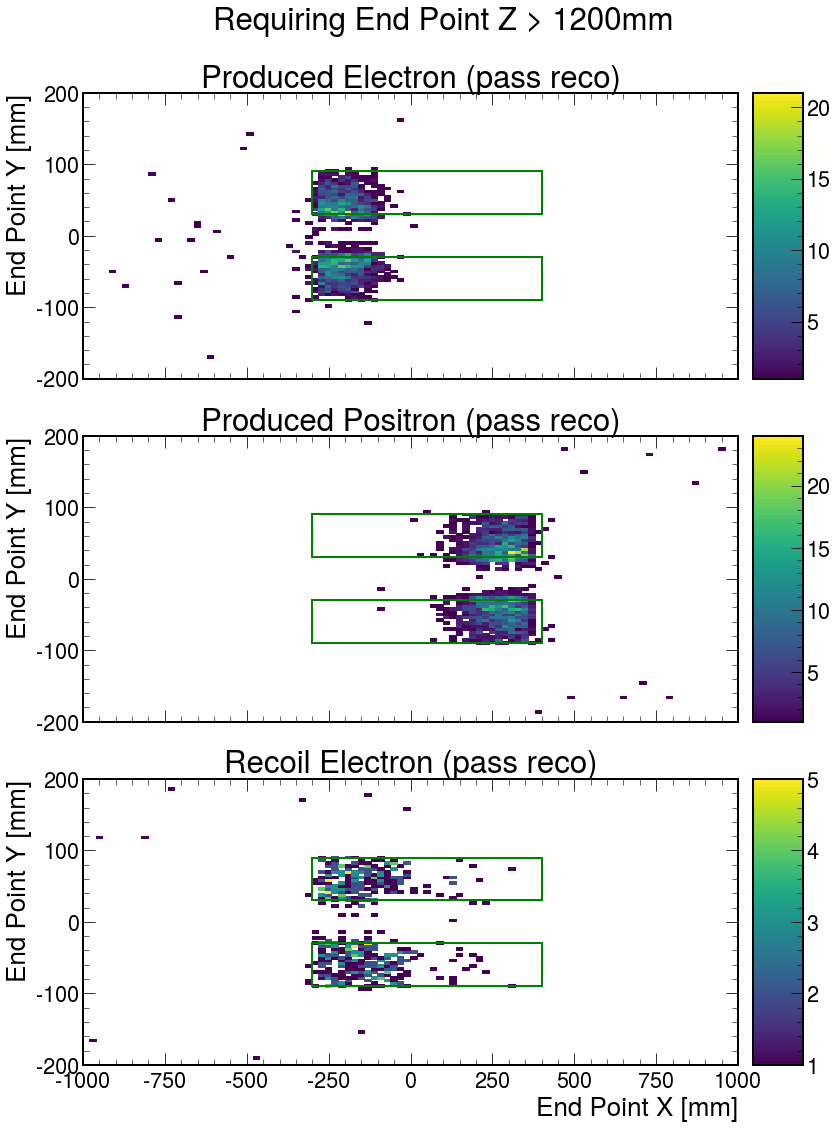

In [24]:
h = hist.Hist(
    hist.axis.StrCategory(
        list(obs.keys())
    ),
    hist.axis.Regular(
        100,-1000,1000,
        label = 'End Point X [mm]'
    ),
    hist.axis.Regular(
        100,-200,200,
        label = 'End Point Y [mm]'
    )
)
for name, particle in obs.items():
    h.fill(name, particle.ep.x[particle.ep.z > 1200], particle.ep.y[particle.ep.z > 1200])

#h[:,:,sum].plot(density=True)
#plt.legend()
#plt.show()

#h[:,sum,:].plot(density=True)
#plt.yscale('log')
#plt.legend()
#plt.show()
fig, axes = plt.subplots(
    nrows = 3,
    sharex = 'col',
    gridspec_kw = dict(
        left=0, right=1,
        bottom=0, top=0.9
    )
)
fig.set_figheight(1.5*fig.get_figheight())

for i, (particle, ax) in enumerate(zip([k for k in obs.keys() if 'reco' not in k], axes)):
    h[particle,:,:].plot(ax=ax, cmin=1)
    ax.add_patch(mpl.patches.Rectangle(
        (-300,-90), 700, 60,
        lw = 2,
        edgecolor = 'g',
        facecolor = 'none'
    ))
    ax.add_patch(mpl.patches.Rectangle(
        (-300,30), 700, 60,
        lw = 2,
        edgecolor = 'g',
        facecolor = 'none'
    ))
    ax.set_title(particle)
    if i != 2:
        ax.set_xlabel('')
fig.suptitle('Requiring End Point Z > 1200mm')
fig.savefig('plots/obs-mc-xy.pdf', bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(
    nrows = 3,
    sharex = 'col',
    gridspec_kw = dict(
        left=0, right=1,
        bottom=0, top=0.9
    )
)
fig.set_figheight(1.5*fig.get_figheight())

for i, (particle, ax) in enumerate(zip([k for k in obs.keys() if 'reco' in k], axes)):
    h[particle,:,:].plot(ax=ax, cmin=1)
    ax.add_patch(mpl.patches.Rectangle(
        (-300,-90), 700, 60,
        lw = 2,
        edgecolor = 'g',
        facecolor = 'none'
    ))
    ax.add_patch(mpl.patches.Rectangle(
        (-300,30), 700, 60,
        lw = 2,
        edgecolor = 'g',
        facecolor = 'none'
    ))
    ax.set_title(particle)
    if i != 2:
        ax.set_xlabel('')
fig.suptitle('Requiring End Point Z > 1200mm')
fig.savefig('plots/obs-mc-pass-reco-xy.pdf', bbox_inches='tight')
plt.show()

In [58]:
nhits = hist.Hist(
    hist.axis.Regular(
        65,-80,180,
        name='vtxz',
        label='Vertex Z [mm]'
    ),
    hist.axis.Regular(
        start=0, stop=100, bins=100, 
        flow=True,
        name='nhits',
        label='Num Ecal Sim Hits'
    ),
    hist.axis.Regular(
        20,0,2,
        name='ecal_sim_energy',
        label='Sim ECal Energy [GeV]'
    ),
).fill(
    vtxz = chi2.ep.z,
    nhits = ak.count(ecal_hits.x, axis=1),
    ecal_sim_energy = ak.sum(ecal_hits.energy, axis=1),
)

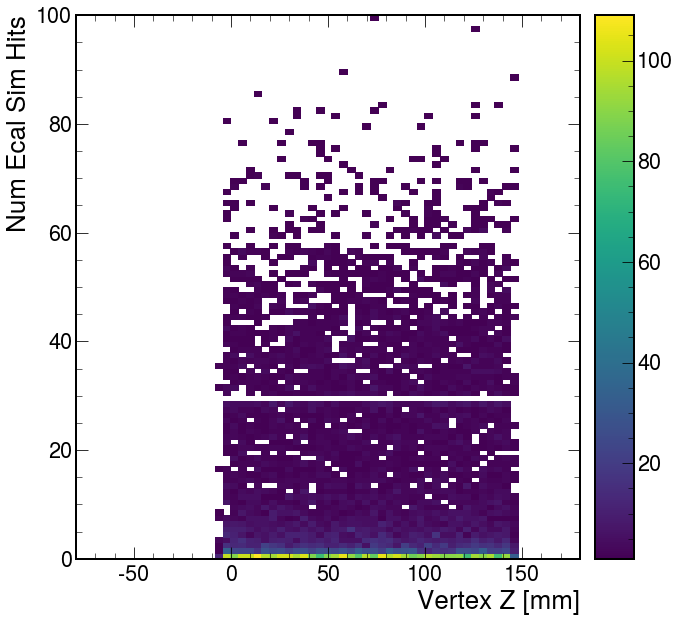

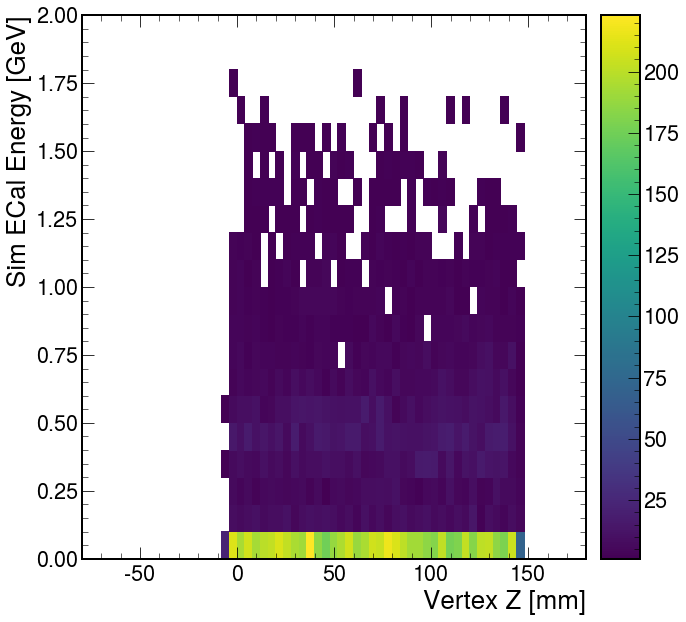

In [61]:
nhits[:,:,sum].plot(cmin = 1)
plt.show()
nhits[:,sum,:].plot(cmin = 1)
plt.show()

# Ana

In [195]:
f = uproot.open('test_ana.root')

In [196]:
selection_cutflow = f['idmpre_vtxSelection_cutflow'].to_hist()

In [198]:
selection_cutflow.axis('x')

AttributeError: 'Hist' object has no attribute 'axis'

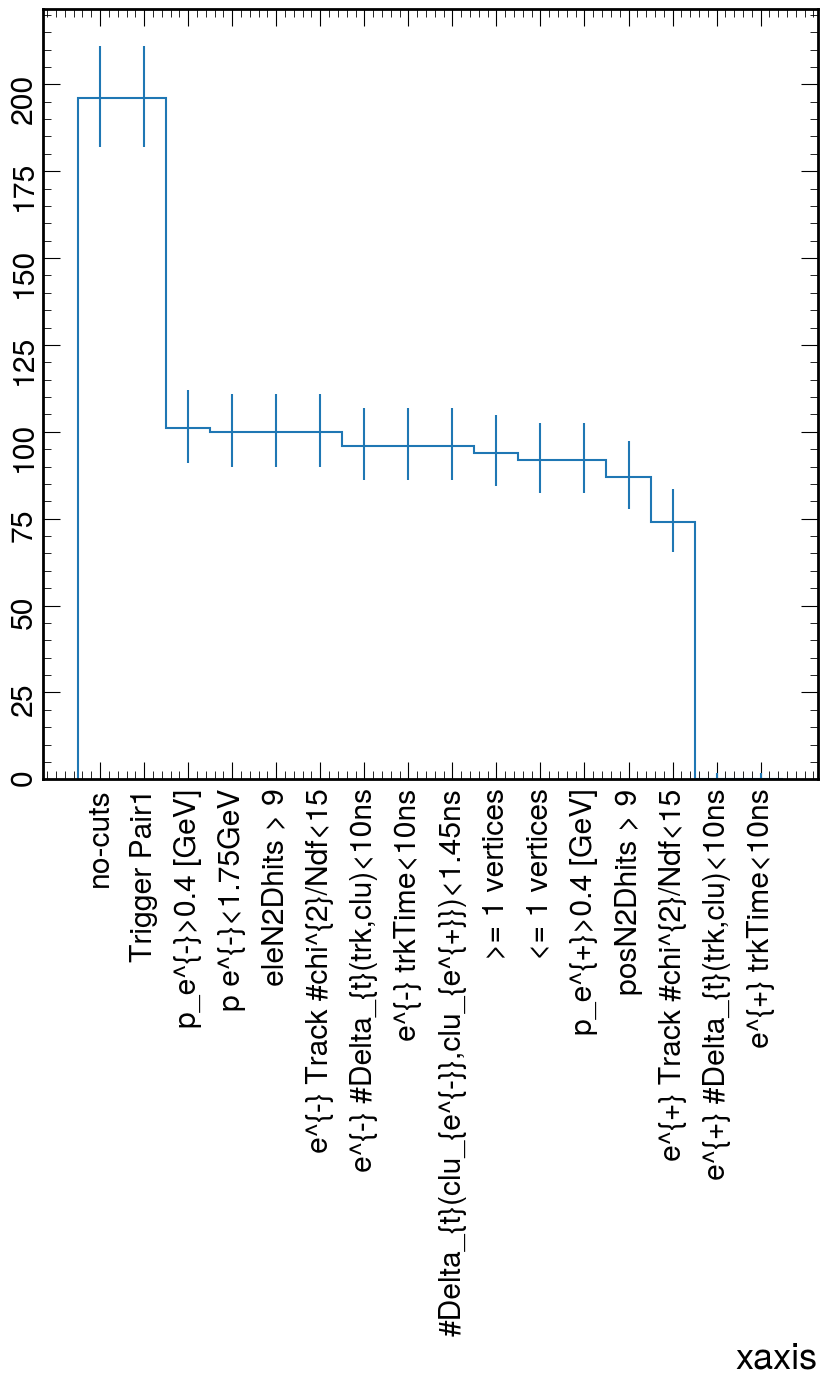

In [197]:
selection_cutflow.plot()
plt.tick_params(labelrotation=90)

(array([ 95.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 <BarContainer object of 9 artists>)

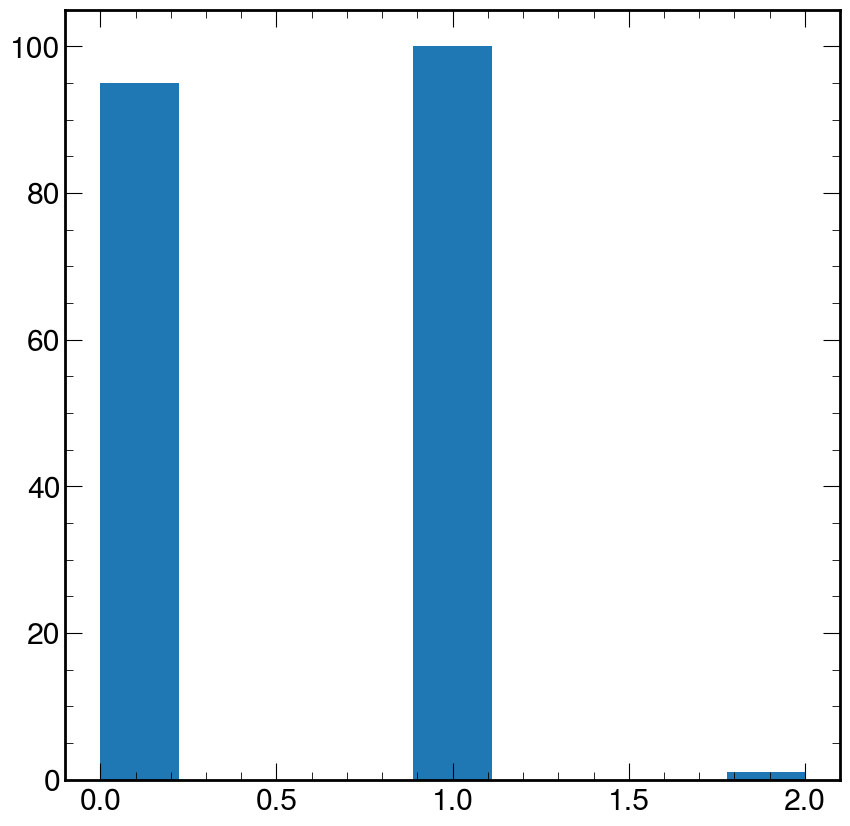

In [187]:
plt.hist(ak.count(reco_events['UnconstrainedV0Vertices_KF/UnconstrainedV0Vertices_KF.chi2_'], axis=1),bins='auto')

In [212]:
reco_events = coffea.nanoevents.NanoEventsFactory.from_root(
    'test.root', 'HPS_Event',
    schemaclass=coffea.nanoevents.BaseSchema,
    metadata={'dataset':'test'},
).events()

NotImplementedError: memberwise serialization of AsArray
in file test.root

In [157]:
reco_events['EventHeader/pair1_trigger_']

<Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * int32[parameters=...'>

In [158]:
candidates = coffea.nanoevents.NanoEventsFactory.from_root(
    'test_ana.root', 'iDMCandidates',
    schemaclass=coffea.nanoevents.BaseSchema,
    metadata={'dataset':'test'},
).events()

KeyError: 'e9d48440-2a49-11ee-8e0e-4db45ea0beef:/iDMCandidates;1:vtx(1)/parts_(13)'

In [148]:
ak.zip({'reco':reco_events, 'candidates':candidates})

<Array [{reco: {...}, ...}, {...}, ..., {...}] type='196 * {reco: event, ca...'>

## Experimental Schema
Trying to play with `ak.zip` to make form of awkward arrays better.

In [213]:
f = uproot.open('test.root')

In [215]:
f['HPS_Event'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
EventHeader          | EventHeader              | AsGroup(<TBranchElement 'Ev...
EventHeader/TObject  | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
EventHeader/TObje... | uint32_t                 | AsDtype('>u4')
EventHeader/TObje... | uint32_t                 | AsDtype('>u4')
EventHeader/event... | int32_t                  | AsDtype('>i4')
EventHeader/event... | int64_t                  | AsDtype('>i8')
EventHeader/run_n... | int32_t                  | AsDtype('>i4')
EventHeader/pair0... | int32_t                  | AsDtype('>i4')
EventHeader/pair1... | int32_t                  | AsDtype('>i4')
EventHeader/pulse... | int32_t                  | AsDtype('>i4')
EventHeader/singl... | int32_t                  | AsDtype('>i4')
EventHeader/singl... | int32_t                  | AsDtype('>i4')
EventHeader/svt_b... | int

In [217]:
f['HPS_Event'].arrays(
    filter_name=['MCParticle/*', 'UnconstrainedV0Vertices_KF/*']
)

NotImplementedError: memberwise serialization of AsArray
in file test.root

In [41]:
for field in events.fields:
    if all([f.startswith(field) for f in events[field].fields]):
        events[field] = {
            f.strip(field+'.'): events[field][f]
            for f in events[field].fields
        }

In [42]:
events

<Array [{EventHeader: {...}, ...}, ..., {...}] type='196 * {EventHeader: {f...'>

In [30]:
import re
form = {}
for br in events.fields:
    sub_branches = re.split('[/.]', br)
    condensed_sub_branches = [
        b
        for i, b in enumerate(sub_branches)
        if i==0 or b != sub_branches[i-1]
    ]
    location = form.get(condensed_sub_branches[0], dict())
    form[condensed_sub_branches[0]] = location
    for b in condensed_sub_branches[1:-1]:
        sub = location.get(b, dict())
        location[b] = sub
        location = sub
    if condensed_sub_branches[-1] == 'parameters_':
        continue
    location[condensed_sub_branches[-1]] = events[br]

def recurzip(form):
    if isinstance(form, ak.Array):
        return form
    
    if all([isinstance(value, ak.Array) for value in form.values()]):
        print()
        print(form)
        return ak.zip(form)
    
    for field in form:
        form[field] = recurzip(form[field])
    
recurzip(form)


{'fUniqueID': <Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * uint32[parameters...'>, 'fBits': <Array [50331648, 50331648, ..., 50331648] type='196 * uint32[parameters={"...'>}

{'fUniqueID': <Array [0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0] type='196 * uint32[parameters...'>, 'fBits': <Array [50331648, 50331648, ..., 50331648] type='196 * uint32[parameters={"...'>}

{'blocklevel': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'blocknum': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'nothing': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'slotid': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'type': <Array [2576980377, ..., 2576980377] type='196 * uint32[parameters={"__doc_...'>, 'istype': <Array [True, True, True, ..., True, True] type='196 * bool[parameters={"__...'>}

{'nwords': <Array [2576980377, ..., 2576980377] type='196 * uint

ValueError: cannot broadcast nested list